Thanks to this article https://medium.com/analytics-vidhya/primer-on-gps-data-with-strava-and-python-cd7c6c1d715a and https://towardsdatascience.com/parsing-fitness-tracker-data-with-python-a59e7dc17418/

Uses this library https://pypi.org/project/gpxpy/

In [1]:
import gpxpy

path = '../Strava/Ronde_Van_Vlaanderen_2022.gpx'

with open(path, 'r') as f:
   gpx = gpxpy.parse(f)

print('Tracks ',len(gpx.tracks))
print(gpx.tracks[0].name)
print('Segments ', len(gpx.tracks[0].segments))
print('Segment Points ', len(gpx.tracks[0].segments[0].points))

data = gpx.tracks[0].segments[0].points

track = gpx.tracks[0]
segment = track.segments[0]
random_point = segment.points[11144]
point = random_point
last_point = segment.points[11143]
random_point

Tracks  1
Ronde Van Vlaanderen 2022
Segments  1
Segment Points  34843


GPXTrackPoint(50.885137, 3.89582, elevation=59.0, time=datetime.datetime(2022, 4, 2, 8, 18, 27, tzinfo=SimpleTZ('Z')))

In [2]:
import mpu

power = None
hr = None
cadence = None
temp = None
# Safely access extensions
for ext in point.extensions:
    if ext.tag.endswith('power'):
        power = ext.text
    if ext is not None:
        for child in ext:
            if (child.tag.endswith('hr')):
                hr = child.text
            if (child.tag.endswith('cad')):
                cadence = child.text
            if (child.tag.endswith('atemp')):
                temp = child.text
duration = point.time - last_point.time
dist = mpu.haversine_distance((point.latitude, point.longitude), (last_point.latitude, last_point.longitude))
print(dist)  # gives 278.45817507541943.
print(duration)
print(point.latitude)
print(power)
print(cadence)
print(hr)

0.006013357686656416
0:00:01
50.885137
234
66
159


In [3]:
import pandas as pd

df = pd.DataFrame(columns=['lat', 'lon', 'ele','time','power', 'hr', 'cad','temperature'
#                           'dist','duration'
                           ])
last_point = None
for point in data:
    power = None
    hr = None
    cadence = None
    temp = None
#    dist = None
#    duration = None
    # Safely access extensions
    for ext in point.extensions:
        if ext.tag.endswith('power'):
            power = int(ext.text)
        if ext is not None:
            for child in ext:
                if (child.tag.endswith('hr')):
                    hr = int(child.text)
                if (child.tag.endswith('cad')):
                    cadence = int(child.text)
                if (child.tag.endswith('atemp')):
                    temp = float(child.text)
#    if (last_point is not None):
#        duration = point.time - last_point.time
#        dist = mpu.haversine_distance((point.latitude, point.longitude), (last_point.latitude, last_point.longitude))
    new_row = pd.DataFrame({'lat': [point.latitude],
                            'lon': [point.longitude],
                            'ele': [point.elevation],
                            'time': [point.time],
                            'power': [power]
                            ,'hr': [hr],
                            'cad': [cadence]
                               ,'temperature': [temp]
#                            ,'duration': [duration]
#                            ,'dist': [dist]
                            })
    df = pd.concat([df, new_row], ignore_index=True)



/var/folders/16/bplm70c55mj7020_2tms62sh0000gn/T/ipykernel_93629/2309579251.py:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


In [9]:
df['hr'] = df['hr'].astype(int)
df['cad'] = df['cad'].astype(int)
df['power'] = df['power'].astype(float)
df['temperature'] = df['temperature'].astype(float)

In [10]:
df

,lat,lon,ele,time,power,hr,cad,temperature
0,51.218620,4.396423,16.6,2022-04-02 05:00:17+00:00,NaN,114,0,6.0
1,51.218620,4.396423,16.6,2022-04-02 05:00:18+00:00,0.0,115,0,6.0
2,51.218623,4.396424,16.4,2022-04-02 05:00:19+00:00,0.0,115,0,6.0
3,51.218670,4.396435,16.4,2022-04-02 05:00:20+00:00,0.0,116,0,6.0
4,51.218674,4.396438,16.4,2022-04-02 05:00:21+00:00,0.0,116,0,6.0
...,...,...,...,...,...,...,...,...
34838,50.843300,3.604234,10.0,2022-04-02 16:10:02+00:00,0.0,122,0,6.0
34839,50.843304,3.604235,10.0,2022-04-02 16:10:03+00:00,0.0,122,0,6.0
34840,50.843307,3.604235,10.2,2022-04-02 16:10:04+00:00,0.0,122,0,6.0
34841,50.843308,3.604235,10.2,2022-04-02 16:10:05+00:00,0.0,121,0,6.0


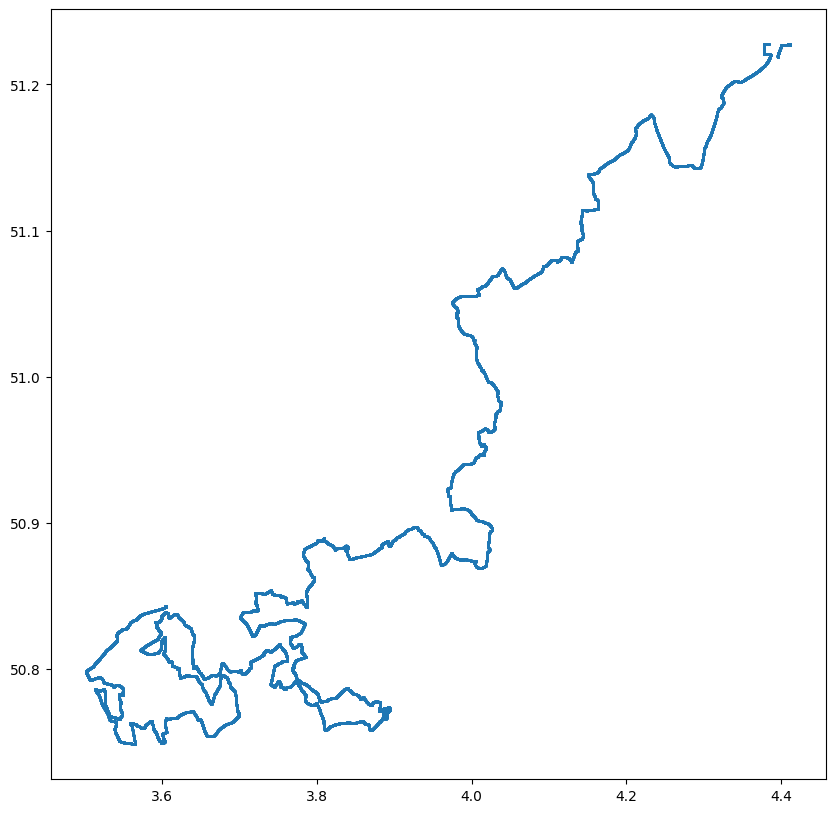

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.plot(df.lon, df.lat, 'o', markersize=1)

time column with time zone causes issues with plotting functions.
Turn the time column into an index

In [11]:
df['time'] = df['time'].dt.tz_localize(None)
df = df.set_index('time')
df.head()

,lat,lon,ele,power,hr,cad,temperature
time,,,,,,,
2022-04-02 05:00:17,51.218620,4.396423,16.6,NaN,114,0,6.0
2022-04-02 05:00:18,51.218620,4.396423,16.6,0.0,115,0,6.0
2022-04-02 05:00:19,51.218623,4.396424,16.4,0.0,115,0,6.0
2022-04-02 05:00:20,51.218670,4.396435,16.4,0.0,116,0,6.0
2022-04-02 05:00:21,51.218674,4.396438,16.4,0.0,116,0,6.0


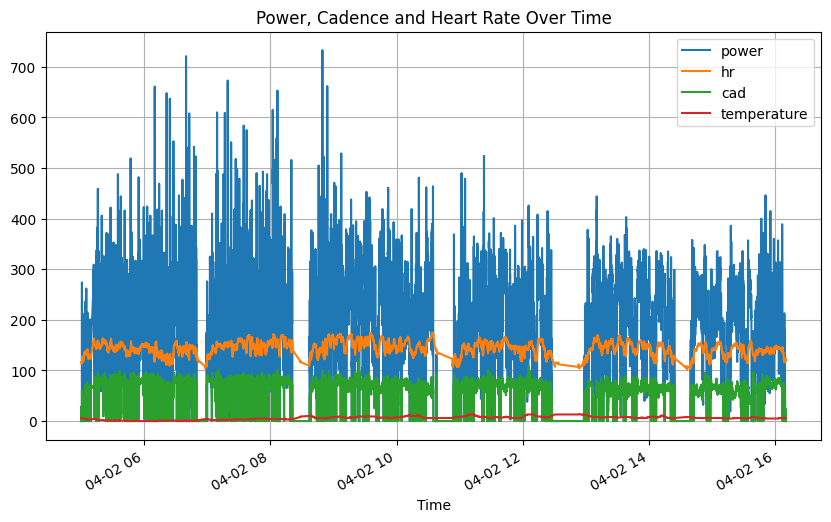

In [12]:
close_px = df[['power','hr','cad','temperature']]
close_px.plot(kind='line',
              figsize=(10, 6),
              title='Power, Cadence and Heart Rate Over Time',
              grid=True,
              legend=True)
plt.xlabel('Time')
plt.show()


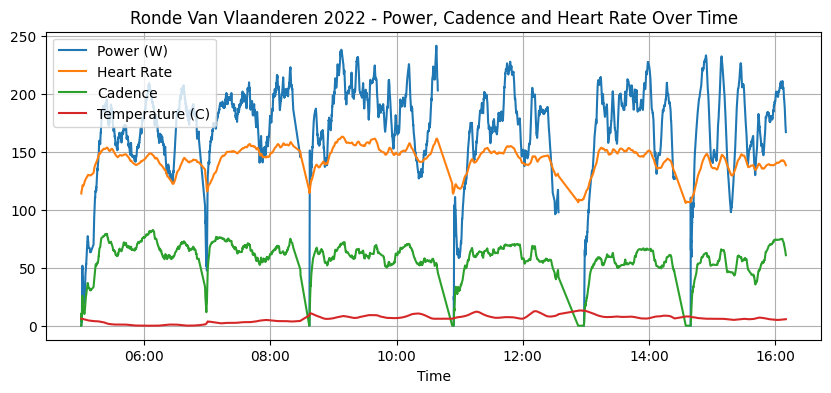

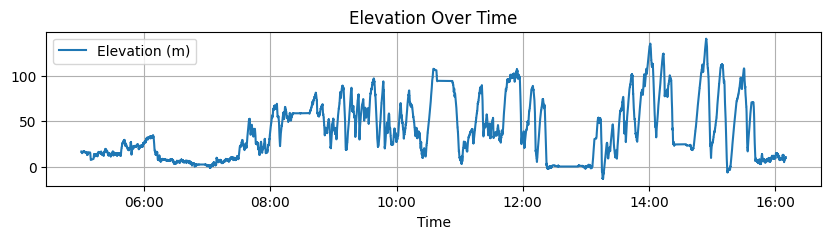

In [13]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

rolling_mean = close_px.rolling('600s').mean()

plt.figure(figsize=(10, 4))
plt.plot(rolling_mean.index, rolling_mean)
plt.xlabel('Time')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.gca().legend(['Power (W)', 'Heart Rate', 'Cadence', 'Temperature (C)'])
plt.title('Ronde Van Vlaanderen 2022 - Power, Cadence and Heart Rate Over Time')
plt.grid(True)
plt.show()

elevation = df[['ele']]
plt.figure(figsize=(10, 2))
plt.plot(elevation.index, elevation)
plt.xlabel('Time')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.gca().legend(['Elevation (m)'])
plt.title('Elevation Over Time')
plt.grid(True)
plt.show()

Calculate values for [Physical Activity - Activity-based Measures](https://build.fhir.org/ig/HL7/physical-activity/measures.html#activity-based-measures)

Convert to FHIR Bundle (type = collection)